<img src="../../../img/logo-bdc.png" align="right" width="64"/>

# <span style="color:#336699"> Web Land Trajectory Service (WLTS) examples</span>
<hr style="border:2px solid #0077b9;">

If you haven't installed the [WLTS client for Python](https://github.com/brazil-data-cube/wlts.py).

This example presents a way to use WLTS to collect samples that can be used for training machine learning algorithms. The sampling methods presented in this document are:

- Random
- Fixed Grid

> **Please, note**: To run this example it is necessary to install the [Verde](https://www.fatiando.org/verde/latest/index.html) library. To run this example it is necessary to install the [rasterio](https://rasterio.readthedocs.io/en/latest/intro.html) library


For more information on [WLTS client for Python](https://github.com/brazil-data-cube/wlts.py), see the introductory Jupyter Notebook about [Web Land Trajectory Service (WLTS)](./wlts-introduction.ipynb) Introduction notebook.

# 1. Load the WLTS and requires libraries. 
<hr style="border:1px solid #0077b9;">

In [1]:
# to reduce some warnings on notebook
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [ ]:
import wlts

import verde as vd

import numpy as np
import pandas as pd

import rasterio.plot
import rasterio as rio

import geopandas as gpd

import matplotlib.pyplot as plt

### 1.1 Help functions

Below the functions used to carry out the sampling process are defined.


In [3]:
from shapely.ops import transform
from shapely.geometry import Point


def transform_crs(crs_src: str, crs_dest: str, geom):    
    """Reproject geometry
    Args:
        crs_src (str): Actual geometry CRS
        crs_dest (str): Destiny geometry CRS
        geom (shapely.geometry.base.BaseGeometry): Shapely Geometry
    Returns:
        shapely.geometry.base.BaseGeometry: Shapely Geometry reprojected
    """
    
    import pyproj
    crs_src = pyproj.CRS(crs_src)
    crs_dest = pyproj.CRS(crs_dest)

    transform_fnc = pyproj.Transformer.from_crs(crs_src, crs_dest).transform
    return transform(transform_fnc, geom)


def get_sample_from_wlts(wlts_service_instance, points_geom, collections):
    """get sample data from WLTS service using multiple geom points
    
    Args:
        wlts_service_instance (wlts.WLTS): WLTS Service instance
        
        points_geom (List[shapely.geometry.Point]): List of geometries
        
        collections (str): string separated by comma with WLTS collections name
    Returns:
        geopandas.GeoDataFrame: GeoTable with locations and labels
    """

    # request from wlts service
    gdf_res = []
    for point in points_geom:
        _res = wlts_service_instance.tj(longitude = float(point.y), latitude = float(point.x), collections=collections).df()
        _res = gpd.GeoDataFrame(_res)
        _res['geometry'] = Point(point.y, point.x)

        gdf_res.append(_res)
    return pd.concat(gdf_res)


**Sampling functions**

In [4]:
def wlts_sampling_by_random_points(wlts_service_instance: wlts.WLTS, raster_path: str, n: int, collections: list) -> gpd.GeoDataFrame:
    """Function to sampling points from WLTS Service by random points in raster bounds
    
    Args:
        wlts_service_instance (wlts.WLTS): WLTS Service object
        
        collections (list): Collections avaliable in wlts service
        
        raster_path (str): raster path or url
        
        n (int): Number of points
    Returns:
        pd.GeoDataFrame: GeoTable with locations and classes 
    """

    def random_sampling_based_on_within_raster_limits(raster_path: str, n: int, offset = 0) -> np.ndarray:
        """Get random locations wihtin raster limits

        Args:
            raster_path (str): raster path or url
            n (int): Number of points
            offset (int): offset to remove from pixel position (To avoid NaN positions)
        Returns:
            list: Generated points 
        """
    
        def random_points(n: int, lowx: int, highx: int, lowy: int, highy: int) -> np.ndarray:
            """Auxiliary function for generating random points in a defined interval

            Args:
                n (int):  Number of points to be generated
                
                lowx (int): Minimum value of point generated in x axis
                
                highx (int): Maximum value of point generated in x axis
                
                lowy (int): Minimum value of point generated in y axis
                
                highy (int): Maximum value of point generated in y axis
            Returns:
                list: Generated points 
            """
            return np.array([
                (np.random.randint(lowx, highx), np.random.randint(lowy, highy)) for i in range(n)
            ])
        rasterds = rio.open(raster_path)

        xmax = rasterds.profile['width'] - offset
        ymax = rasterds.profile['height'] - offset

        return random_points(n, 0, xmax, 0, ymax)
    
    if collections:
        if type(collections) != list:
            raise TypeError("Collections must be an list")
        collections = ",".join(collections)
    
    ds = rio.open(raster_path)
    points = random_sampling_based_on_within_raster_limits(raster_path, n, 0)
    
    # EPSG:4326 is WLTS default CRS
    points_geom = [Point(*ds.xy(*xy)) for xy in points]
    points_geom = [transform_crs(ds.crs, 'EPSG:4326', point) for point in points_geom]
    
    # request from wlts service
    gdf_res = get_sample_from_wlts(wlts_service_instance, points_geom, collections)
    gdf_res.crs = 'EPSG:4326'
    
    return gdf_res


In [5]:
def wlts_sampling_by_grid(wlts_service_instance: wlts.WLTS, raster_path: str, collections: list, **kwargs) -> gpd.GeoDataFrame:
    """Function to sampling points from WLTS Service using a defined grid over raster bounds
    
    Args:
        wlts_service_instance (wlts.WLTS): WLTS Service object
        
        collections (list): Collections avaliable in wlts service
        
        raster_path (str): raster path or url
        
        n (int): Number of points
        
        kwargs: args to verde.grid_coordinates (spacing and others)
        
    Returns:
        pd.GeoDataFrame: GeoTable with locations and classes 
    """
    
    def create_points_by_grid_region(bounds: tuple, **kwargs):
        """Generate a sample of points using a grid

        Args:
            bounds (tuple): Tuple with west, east, south, north definition. 
            (Can be defined as geographical coordinates or matrix position)

            spacing (number): Space between each element
        Returns:
            tuple: Tuple with array for x and y grid location
        """
        
        if len(bounds) != 4: 
            raise RuntimeError("bounds must be contains west, east, south, north elements")
    
        return vd.grid_coordinates(region = bounds, **kwargs)
    
    if collections:
        if type(collections) != list:
            raise TypeError("Collections must be a list")
        collections = ",".join(collections)
    
    ds = rio.open(raster_path)
    bounds = 0, ds.profile['width'], 0, ds.profile['height'] 
    
    # generating a grid region
    easting, northing = create_points_by_grid_region(bounds, **kwargs)
        
    # EPSG:4326 is WLTS default CRS
    points_geom = []
    for i, j in zip(northing, easting):
        points_geom.extend([
            Point(*ds.xy(x, y)) for x, y in zip(i, j)
        ])
    
    points_geom = [transform_crs(ds.crs, 'EPSG:4326', point) for point in points_geom]
    samples = get_sample_from_wlts(wlts_service_instance, points_geom, collections)
    samples.crs = 'EPSG:4326'
    
    return samples


# 2. Set the service and general definitions
<hr style="border:1px solid #0077b9;">

Initially, a connection to the WLTS server will be created, which allows the recovery of the information. This process is done with the use of the [wlts.py library](https://github.com/brazil-data-cube/wlts.py).

In [6]:
service = wlts.WLTS('https://brazildatacube.dpi.inpe.br/wlts')

Also, a data cube generated by the Brazil Data Cube (BDC) project will be used. Its use is made so that a region's boundaries can be defined during the sampling process in both methods.

> All data products being generated by the BDC project can be consulted and consumed through the STAC catalog service. For more information, consult the [BDC-STAC repository](https://github.com/brazil-data-cube/stac.py).


In [8]:
# BDC's data cube (NDVI from a LC8 cube collection)
raster_url = 'https://brazildatacube.dpi.inpe.br/data/d006/Mosaic/CB4_64_16D_STK/v001/020024/2020-07-27_2020-08-11/CB4_64_16D_STK_v001_020024_2020-07-27_2020-08-11_NDVI.tif?access_token=XXXXXXXXXX'

cube = rio.open(raster_url)

# 3. Random Sampling
<hr style="border:1px solid #0077b9;">

The first sampling method presented will be a **random**. In this method, within the raster's spatial extension being used as a reference, random points will be collected. For each point collected, its class is searched in the collection that is being used.

> This method is implemented through the `wlts_sampling_by_random_points` method. It receives the instance of the WLTS service, the raster used as a reference for the generation of the spatial limits, and the collection that must be consulted to get the classes.

> `n` is the number of random generated points


In [9]:
samples_by_random = wlts_sampling_by_random_points(service, 
                                                   raster_path = raster_url, 
                                                   n           = 120, 
                                                   collections = ['mapbiomas5_amazonia'])

samples_by_random

,class,collection,date,geometry
0,Formação Florestal,mapbiomas5_amazonia,2000,POINT (-58.22250 -16.45979)
1,Pastagem,mapbiomas5_amazonia,2001,POINT (-58.22250 -16.45979)
2,Pastagem,mapbiomas5_amazonia,2002,POINT (-58.22250 -16.45979)
3,Pastagem,mapbiomas5_amazonia,2003,POINT (-58.22250 -16.45979)
4,Pastagem,mapbiomas5_amazonia,2004,POINT (-58.22250 -16.45979)
...,...,...,...,...
15,Pastagem,mapbiomas5_amazonia,2015,POINT (-60.56657 -12.26372)
16,Pastagem,mapbiomas5_amazonia,2016,POINT (-60.56657 -12.26372)
17,Pastagem,mapbiomas5_amazonia,2017,POINT (-60.56657 -12.26372)
18,Pastagem,mapbiomas5_amazonia,2018,POINT (-60.56657 -12.26372)


Visualizing sampling result

<AxesSubplot:>

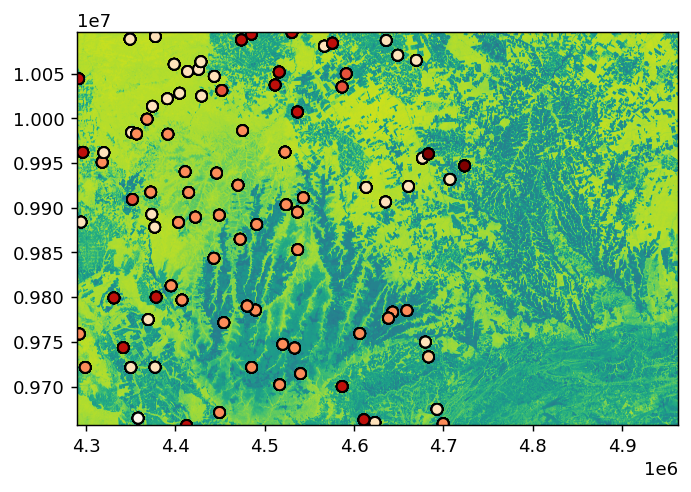

In [10]:
_, ax = plt.subplots(dpi = 130)

points_in_ds_crs = samples_by_random.to_crs(cube.crs)
points_in_ds_crs.plot(ax        = ax,
                      column    = 'class', 
                      cmap      = 'OrRd', 
                      facecolor = 'none', 
                      edgecolor = 'black')
rasterio.plot.show((cube, 1), ax = ax)

> Note that this plot was made just to confirm the locations. Interpretations should be made considering the characteristics of the data!

# 4. Fixed Grid Sampling
<hr style="border:1px solid #0077b9;">

The second sampling method is the fixed grid. In this method, it is made the creation of a grid, with fixed spacing, so that, for each grid point, it is made the recovery of the class of its location.

> This method is implemented by the `wlts_sampling_by_grid` function, which receives the same parameters presented by the `wlts_sampling_by_random_points` function.

> The `spacing` parameter is used to determine the space between the grid points. Other parameters can be passed (see the valid parameters for the `verde.grid_coordinates` function).


In [11]:
samples_by_grid = wlts_sampling_by_grid(service, raster_url, ['mapbiomas5_amazonia'], spacing = 1500)

samples_by_grid

,class,collection,date,geometry
0,Formação Florestal,mapbiomas5_amazonia,2000,POINT (-60.59318 -11.06782)
1,Formação Florestal,mapbiomas5_amazonia,2001,POINT (-60.59318 -11.06782)
2,Formação Florestal,mapbiomas5_amazonia,2002,POINT (-60.59318 -11.06782)
3,Formação Florestal,mapbiomas5_amazonia,2003,POINT (-60.59318 -11.06782)
4,Formação Florestal,mapbiomas5_amazonia,2004,POINT (-60.59318 -11.06782)
...,...,...,...,...
15,No-Data,mapbiomas5_amazonia,2015,POINT (-54.35212 -15.05468)
16,No-Data,mapbiomas5_amazonia,2016,POINT (-54.35212 -15.05468)
17,No-Data,mapbiomas5_amazonia,2017,POINT (-54.35212 -15.05468)
18,No-Data,mapbiomas5_amazonia,2018,POINT (-54.35212 -15.05468)


# 5.Visualizing sampling result
<hr style="border:1px solid #0077b9;">

<AxesSubplot:>

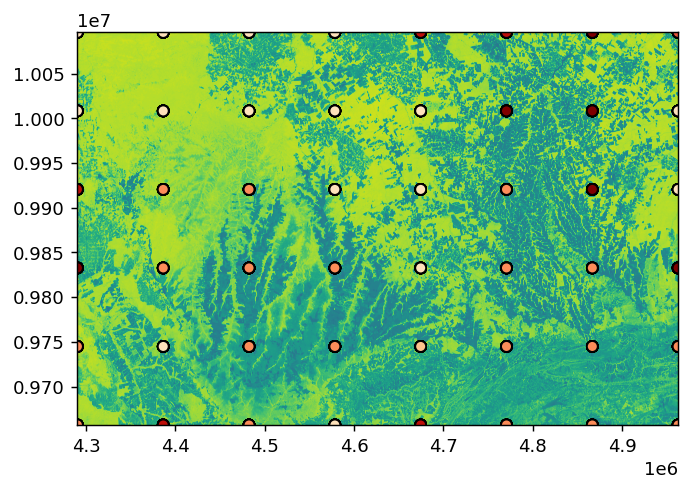

In [12]:
_, ax = plt.subplots(dpi = 130)

points_in_ds_crs = samples_by_grid.to_crs(cube.crs)
points_in_ds_crs.plot(ax        = ax,
                      column    = 'class', 
                      cmap      = 'OrRd', 
                      facecolor = 'none', 
                      edgecolor = 'black')
rasterio.plot.show((cube, 1), ax = ax)

# 6. References
<hr style="border:1px solid #0077b9;">

- [Python Client Library for Web Land Trajectory Service - User Guide](https://wtss.readthedocs.io/en/latest/index.html)


- [Python Client Library for Web Land Trajectory Service - GitHub Repository](https://github.com/brazil-data-cube/wlts.py)


- [WLTS OpenAPI 3 Specification](https://github.com/brazil-data-cube/wlts-spec)


- [WLTS Server](https://github.com/brazil-data-cube/wlts)

# 7. See other WLTS's Jupyter Notebooks
<hr style="border:1px solid #0077b9;">

* [WLTS Introduction](./wlts-introduction.ipynb)